In [158]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [159]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.size" : 16,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

Past lecture
* State space models: introduction

Today's lecture
* State space models - 2

# Lecture 11. State space models - 2

## Reminder of a previous lecture

### Bayes formula

Bayes formula, describing a posteriori probabilities to model parameters $p$ accounting for the observed data:
$$
P(p|\textrm{observations})=\frac{P(\textrm{observations}|p)P(p)}{P(\textrm{observations})}
$$

where $P(\textrm{observations}|p)$ is likelihood of observations given model parameters and $P(p)$ -- a priori probability encoding our beliefs about $p$. Denominator in Bayes formula is $p$ -- independent and is thus is just a normalization factor.

### Linear dynamic systems: simple example

The state equation: $x_{t}=x_{t-1} + u_{t-1} + \epsilon_{t-1}$

The observational equation: $z_{t}=x_{t} + \eta_{t}$

Here:
* $x_t$: true position of the car (unknown)
* $z_t$: measured position of the car (known)
* $u_t$: velocity of the car (known)
* $\epsilon_t$: control error (unknown) 
* $\eta_t$: measurment error (unknown) 

Finally, we assume that errors are uncorrelated and normally distributed:
$P(\epsilon_t)=\mathcal{N}(0,\sigma)$, $P(\eta_t)=\mathcal{N}(0,\rho)$

For example, after two observations $z_1$ and $z_2$, the joint probability of hidden states $x_0$ and $x_1$ is proportional to
$$
P(x_0,x_1|\textrm{observations})\propto P(\eta_0,\eta_1,\epsilon_0|x_0,x_1)=\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{\eta_0^2}{2\rho^2}\right)\cdot\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{\eta_1^2}{2\rho^2}\right)\cdot\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\epsilon_0^2}{2\sigma^2}\right)
$$

Using the state and observational equations, we find
$$
P(x_0,x_1|\textrm{observations})\propto \frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{(x_0-z_0)^2}{2\rho^2}\right)\cdot\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{(x_1-z_1)^2}{2\rho^2}\right)\cdot\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(x_1-x_0-u_0)^2}{2\sigma^2}\right)
$$

For exmple, marginal probability of $x_1$ after two observations reads:

$$
P(x_1|\textrm{observations})\propto\int P(x_0,x_1|\textrm{observations})dx_0=\frac{\exp \left(-\frac{1}{2} \left(\frac{(u_0+z_0-x_1)^2}{\rho ^2+\sigma ^2}+\frac{(x_1-z_1)^2}{\rho ^2}\right)\right)}{2 \pi  \rho  \sqrt{\rho ^2+\sigma ^2}}
$$

Importantly, it is a normal distribution with mean 
$$
\frac{\rho ^2 (u_0+z_0+z_1)+\sigma ^2 z_1}{2 \rho ^2+\sigma ^2}
$$
and standard deviation
$$
\frac{1}{\sqrt{\frac{1}{\rho^2}+\frac{1}{\rho^2+\sigma^2}}}
$$

### Kalman filter

This is generalized to arbirary number of sequential observations, the expected value of the hidden state $x_t$ and its mean squared error are:

$$
\hat x_t \quad\textrm{and}\quad\textrm{err}_t^2,
$$

which may be found recursively:
$$
\hat x_t = K_t z_t + (1-K_t) (\hat x_{t-1}+u_{t-1})
$$

or, equivalently:
$$
\boxed{\hat x_t =\hat x_{t-1}+u_{t-1} + K_t (z_t - (\hat x_{t-1}+u_{t-1}))}
$$

which can be interpreted as sum two terms:
* predicted fore the new hidden state which could have been made before the new observation arrived
* weighted difference between arrived observation and observation which may have been predicted

The weight is determined recursively:

$$
K_t = \frac{\textrm{err}_{t-1}^2+\sigma^2}{\textrm{err}_{t-1}^2+\sigma^2+\rho^2}
$$
and
$$
\textrm{err}_t^2=\rho^2\frac{\textrm{err}_{t-1}^2+\sigma^2}{\textrm{err}_{t-1}^2+\rho^2+\sigma^2}
$$

We are now equipped to do the filtering for our full time series.

In [161]:
rho = 5
sigma = 1

In [373]:
z = np.load("z_1d.npy")
u = np.load("u_1d.npy")

In [374]:
T = len(z)
err2 = np.zeros(T)
x_est = np.zeros(T)
K = np.zeros(T)
err2[0] = rho**2
K[0] = 1
x_est[0] = z[0]

In [375]:
for i in range(1, T):
    K[i] = (err2[i-1] + sigma**2)/(err2[i-1] + sigma**2 + rho**2)
    err2[i] = rho**2 * K[i]
    x_est[i] = K[i] * z[i] + (1-K[i])*(x_est[i-1]+u[i-1])

In [376]:
def show(k):
    plt.plot(np.arange(T)[:k], x_est[:k])
    plt.fill_between(np.arange(T)[:k], x_est[:k]+2*err2[:k]**0.5, x_est[:k]-2*err2[:k]**0.5, alpha=.5)
    plt.title('estimated trajectory of the hidden state');

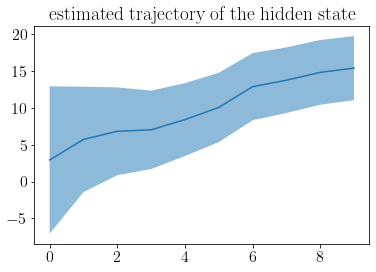

In [377]:
show(10)

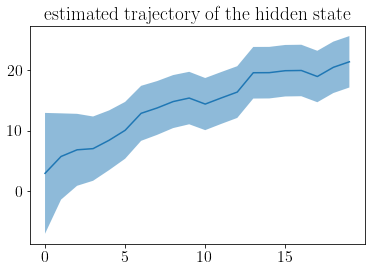

In [378]:
show(20)

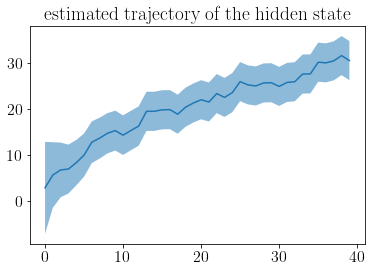

In [379]:
show(40)

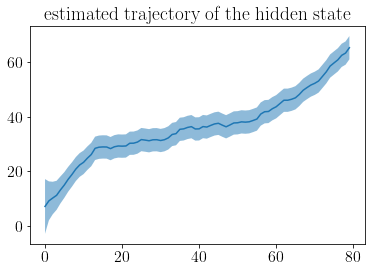

In [365]:
show(80)

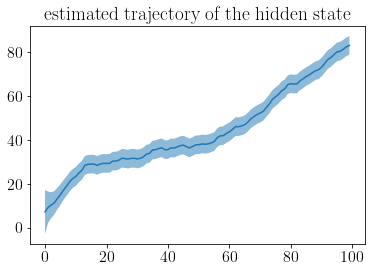

In [366]:
show(100)

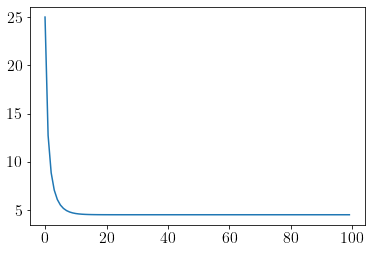

In [367]:
plt.plot(err2)

## What is smoothing in this example and how to do it?

Smoothing is recovery of the most likely trajestory after all observation have arrived. Formally, this takes to maximize, over $x_0,\;x_1,\;...,\;x_T$:

$$
P(x_0,x_1,...,x_T)|\textrm{observations}(t=T))\propto P(\eta_0,...,\eta_T,\epsilon_0,...,\epsilon_{T-1}|x_0,x_1,...,x_T)=\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{\eta_0^2}{2\rho^2}\right)\cdot...\cdot\frac{1}{\sqrt{2\pi}\rho}\exp\left(-\frac{\eta_T^2}{2\rho^2}\right)\cdot\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\epsilon_0^2}{2\sigma^2}\right)\cdot...\cdot\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{\epsilon_{T-1}^2}{2\sigma^2}\right)
$$

Through the state and observational equations: $\epsilon_{t-1}=x_{t}-x_{t-1}-u_{t-1}$, $\eta_{t}=x_{t}-z_{t}$ th RHS becomes a function of $x_0, ..., x_T$ and known parameters.

Is it an easy task to maximize this expression?

Only expression in the explonential depends in $x=(x_0, ..., x_T)$, it reads:
$$
-\frac12 x^T A x + b x + c,
$$
with certain $A, b, c$.

For example, for $T=3$ we have:
$$
A = \left(
\begin{array}{cccc}
 \frac{1}{\rho ^2}+\frac{1}{\sigma ^2} & -\frac{1}{\sigma ^2} & 0 & 0 \\
 -\frac{1}{\sigma ^2} & \frac{1}{\rho ^2}+\frac{2}{\sigma ^2} & -\frac{1}{\sigma ^2} & 0 \\
 0 & -\frac{1}{\sigma ^2} & \frac{1}{\rho ^2}+\frac{2}{\sigma ^2} & -\frac{1}{\sigma ^2} \\
 0 & 0 & -\frac{1}{\sigma ^2} & \frac{1}{\rho ^2}+\frac{1}{\sigma ^2} \\
\end{array}
\right)
$$
and
$$
b = \left\{\frac{z_0}{\rho ^2}-\frac{u_0}{\sigma ^2},\frac{u_0-u_1}{\sigma ^2}+\frac{z_1}{\rho ^2},\frac{u_1-u_2}{\sigma ^2}+\frac{z_2}{\rho ^2},\frac{u_2}{\sigma ^2}+\frac{z_3}{\rho ^2}\right\}
$$
so that we have to solve
$$
A x^* = b
$$

Is it an esy task to solve this system?

Note that after the forward pass (filtering), we know $\hat x_T$ which already accounts for all observations. That is, we know the $x_{T}^*\equiv \hat x_T$. How to proceed?

$$\boxed{
-\frac{1}{\sigma^2}x_{T-1}^* + (\frac{1}{\rho^2}+\frac{1}{\sigma^2})x^*_T = \frac{u_2}{\sigma ^2}+\frac{z_3}{\rho ^2}}
$$

$$
\boxed{-\frac{1}{\sigma^2}x_{T-2}^* + (\frac{1}{\rho^2}+\frac{2}{\sigma^2})x^*_{T-1}-\frac{1}{\sigma^2}x_{T}^*= \frac{u_1-u_2}{\sigma ^2}+\frac{z_2}{\rho ^2}}
$$

$$
...
$$

Thus, the system can be solved in $T$ steps, instead of (naively) $T^3$ steps.

Lets do this for our mechanical example. For the short sequence, its possible to just solve the system directly.

In [380]:
A = np.diag([1/rho**2+1/sigma**2] + [1/rho**2+2/sigma**2]*(T-2) + [1/rho**2+1/sigma**2]) - np.eye(T, k=1)/sigma**2 - np.eye(T, k=-1)/sigma**2
b = [z[0]/rho**2-u[0]/sigma**2] + [(u[i]-u[i+1])/sigma**2 + z[i+1]/rho**2 for i in range(T-2)] + [z[T-1]/rho**2+u[T-2]/sigma**2]
x_star = np.linalg.solve(A, b)

Lets check that, indeed, $\hat{x}_{T} = x_{T}^*$

In [352]:
x_est[-1]

-1.166666914262042

In [353]:
x_star[-1]

-1.1666669142620418

In [354]:
x_est[-2]

-0.06494161288032474

In [357]:
x_star[-2]

-0.9153130273684653

And compare two trajectories

In [174]:
x_true = np.load("x_1d.npy")

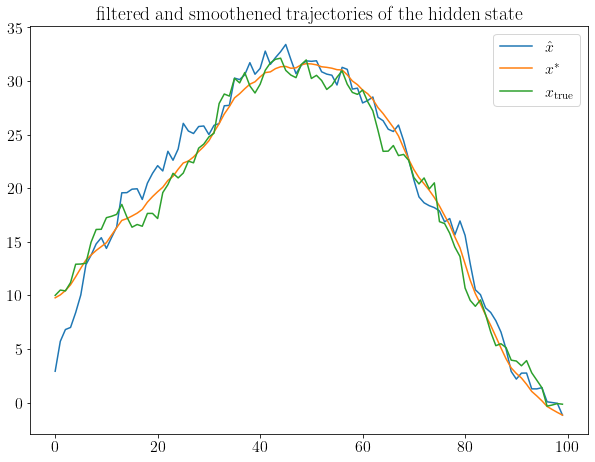

In [381]:
plt.figure(figsize=(10, 7.5))
plt.plot(np.arange(T), x_est)
plt.plot(np.arange(T), x_star)
plt.plot(np.arange(T), x_true)
plt.legend(["$\hat x$", "$x^*$", "$x_{\mathrm{true}}$"])
plt.title('filtered and smoothened trajectories of the hidden state');

Note that after the backwards path we estimate much better the initial position of the car. How to plot the error bar for the smoothened trajectory? Recall that for $x=(x_0, ..., x_T)$, we have:

$$
P(x) \propto e^{-\frac12 x^T A x + b x}
$$

with certain $A, b, c$. This is a multivariate Gaussian distribution, centered at $x=x^*$ and $x^*$ we have just computed. How do we evaluate the mean square errors:

$$
\left<\left(x_i-x_i^*\right)^2\right>?
$$

Observe that $$
P(x) \propto e^{-\frac12 (x-x^*)^T A (x-x^*)},
$$
hence $A=\Omega^{-1}$ is just inverse covariance matrix of $x-x^*$.

In [382]:
err2 = np.diag(np.linalg.inv(A))**0.5

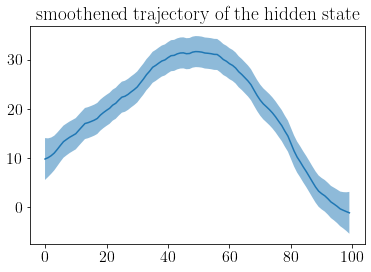

In [383]:
plt.plot(np.arange(T), x_star)
plt.fill_between(np.arange(T), x_star+2*err2, x_star-2*err2, alpha=.5)
plt.title('smoothened trajectory of the hidden state');

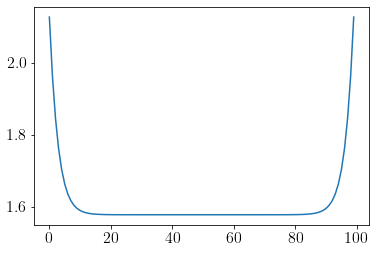

In [384]:
plt.plot(err2)

# General Linear Dynamic Model

The transition model is a linear function

$$
z_t = A_t z_{t-1} + B_t u_t + \epsilon_t
$$

The observation model is a linear function

$$
y_t = C_t z_t + D_t u_t + \delta_t
$$

The system noise is Gaussian

$$
\epsilon_t\sim \mathcal{N}(0, Q_t)
$$

The observation noise is Gaussian

$$
\delta_t\sim \mathcal{N}(0, R_t)
$$

This is a general form of what is called a linear-Gaussian SSM (LG-SSM) or linear dynamical system (LDS). If the parameters 
$$
\theta_t=(A_t, B_t, C_t, D_t, Q_t, R_t)
$$
are independent of time, the model is called stationary.

This model is important because it supports eact inference. In particular, if the initial belief state is Gaussian, $p(z_1)=\mathcal{N}(\mu_{1},\Sigma_1|0)$, then all subsequent belief states will also be Gaussian (here $\Sigma_1|0$ denotes our belief about $\Sigma_1$ before we have seen any data). Updates to these distributions (mean and cov) are computed efficiently using the Kalman filter, which generalizes out previous computation for the most general LDS, formulated above.

### Further Examples 

#### Object tracking

One of the earliest applications of Kalman filtering was for tracking objects, such as airplanes
and missiles, from noisy measurements, such as radar. Consider an object moving in a 2D plane. Let $z_{1t}$ and $z_{2t}$ be the
horizontal and vertical locations of the object, and $\dot{z}_{1t}$ and $\dot{z}_{2t}$ be the corresponding velocity.
We can represent this as a state vector $z_t \in R^4$ as follows:
$$
z_t = (z_{1t},z_{2t},\dot{z}_{1t},\dot{z}_{2t})^T.
$$

Let us assume that the object is moving at constant velocity, but is “perturbed” by random
Gaussian noise (e.g., due to the wind). Thus we can model the system dynamics as follows:
$$
z_t = A_t z_{t-1} + \epsilon_t
$$

with
$$
A_t = \left(
\begin{array}{cccc}
 1 & 0 & \Delta  & 0 \\
 0 & 1 & 0 & \Delta  \\
 0 & 0 & 1 & 0 \\
 0 & 0 & 0 & 1 \\
\end{array}
\right)
$$

where 
$$
\epsilon_t\sim \mathcal{N}(0, Q)
$$

Now suppose that we can observe the location of the object but not its velocity. Let $y_t \in R^2$
represent our observation subject to Gaussian noise:

$$
y_t = C_t z_t + \delta_t
$$
with
$$
C_t = \left(
\begin{array}{cccc}
 1 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 \\
\end{array}
\right)
$$

Finally, we need to specify our prior on the initial state of the object $p(z_1)=\mathcal{N}(z_1|{\mu_{1|0}},\Sigma_{{1|0}})$. Again, it is Gaussian. If we have no idea about the initial location, we may formally take $\Sigma_{1|0}=\infty\hat 1$.

#### Time series model: local linear trend.

Many time series exhibit linear trends upwards or downwards, at least locally. We can model
this by letting the level at change by an amount $b_t$ at each step as follows:

$$
y_t = a_t + \epsilon_t^{y},\quad \epsilon_t^y\sim \mathcal{N}(0, \sigma_y)
$$

$$
a_t = a_{t-1} + b_{t-1}+\epsilon_t^a,\quad \epsilon_t^a\sim \mathcal{N}(0, \sigma_a)
$$

$$
b_t=b_{t-1}+\epsilon_t^b, \quad \epsilon_t^b\sim \mathcal{N}(0, \sigma_b)
$$

This model can be written in a standard form, via $z_t = (a_t, b_t)$ and

$$
A = \left(
\begin{array}{cc}
 1 & 1 \\
 0 & 1 \\
\end{array}
\right),\quad C = \left(1,0\right), \quad Q = \left(
\begin{array}{cc}
 \sigma_a & 0 \\
 0 & \sigma_b \\
\end{array}
\right)
$$

In [204]:
T = 200
sigma_a = 0.05
sigma_b = 1
sigma_y = 25
y = np.zeros(T)
a = 0; b = 0

In [205]:
eps_y = np.random.normal(0, sigma_y, size=T)
eps_a = np.random.normal(0, sigma_a, size=T)
eps_b = np.random.normal(0, sigma_b, size=T)
A = {}; B = {}
A[-1] = a; B[-1] = b

In [206]:
for i in range(T):
    a = a + b + eps_a[i]
    b = b + eps_b[i]
    A[i] = a; B[i] = b
    y[i] = a + eps_y[i]

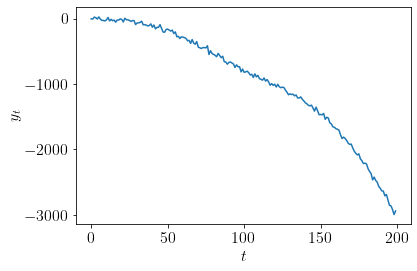

In [210]:
plt.plot(y)
plt.xlabel("$t$")
plt.ylabel("$y_t$");

## The Kalman filtering algorithm

Recall that our goal is to compute
$$
p(z_t|y_{1:t},u_{1:t}) = \mathcal{N}(z_t|\mu_t,\Sigma_t)
$$
while running through the sequence of observations.

#### Prediction

$$
p(z_t|y_{1:t-1},u_{1:t}) = \mathcal{N}(z_t|\mu_{t|t-1},\Sigma_{t|t-1})
$$

Here we are trying to predict the next observation and estimate its variance. This step is simple if the best current estimate is known, due to linearity:
$$
z_t = A_t z_{t-1} + B_t u_t + \epsilon_t
$$

Hence 
$$
\mu_{t|t-1} = A_t\mu_{t-1}+B_t u_t
$$
and
$$
\Sigma_{t|t-1} = A_t\Sigma_{t-1}A_t^T + Q_t
$$

#### Measurement

$$
p(z_t|y_{1:t},u_t) = \mathcal{N}(z_t|\mu_t,\Sigma_t)
$$

$$
\mu_t = \mu_{t|t-1} + K_t r_t,
$$

where $r_t$ is the difference between predicted observation and actually arrived observation:
$$
r_t=y_t -\hat{y}_t,\quad \hat{y}_t = C_t\mu_{t|t-1}+D_tu_t
$$

and
$$
K_t=\left(\Sigma_{t|t-1}^{-1}+C^TRC\right)^{-1}C^TR^{-1}
$$

It is instructive to compare with our little 1D study above and estimate the complexity of the algorithm in dimensions of the hidden state $z$ and observation $y$.

Equation for R is missing!

## The Kalman smoothing algorithm

Filtering is done via "forward" pass through the data. As we may already expect, smoothing works in a "backward" pass. Indeed, after filtering is complete, we know the distribution of the last hidden state, $\mu_{T|T}$ and should compute $\mu_{T-1|T},\mu_{T-1|T},...,\mu_{1|T}$. This is achieved via the following recursion (similar to the one derived above for 1D case):

$$
\mu_{t|T}=\mu_{t|t} + J_t(\mu_{t+1|T}-\mu_{t+1|t})
$$

$$
\Sigma_{t|T} = \Sigma_{t|t} + J_t(\Sigma_{t+1|T}-\Sigma_{t+1|t})J_t^T
$$

where $J_t$ is an analogue of $K_t$ for backward pass:

$$
J_t = \Sigma_{t|t}A_{t+1}^T\Sigma_{t+1|t}^{-1}
$$

# Estimation of Linear Dynamic Models

#### Heuristic approach

Now, imagine tha you have a time series which you believe is described by a local linear trend model, mentioned above:

$$
y_t = a_t + \epsilon_t^{y},\quad \epsilon_t^y\sim \mathcal{N}(0, \sigma_y)
$$

$$
a_t = a_{t-1} + b_{t-1}+\epsilon_t^a,\quad \epsilon_t^a\sim \mathcal{N}(0, \sigma_a)
$$

$$
b_t=b_{t-1}+\epsilon_t^b, \quad \epsilon_t^b\sim \mathcal{N}(0, \sigma_b)
$$

Imagine that you know that $\sigma_a = 0.05$ but $\sigma_b$ and $\sigma_y$ are unknown. And should be estimated from the data.

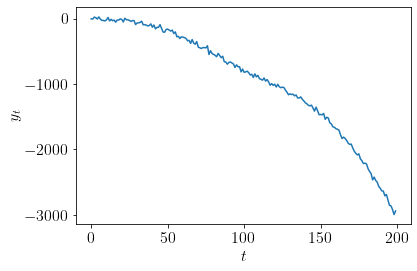

In [238]:
plt.plot(y)
plt.xlabel("$t$")
plt.ylabel("$y_t$");

In principle, we would like to do it in an algorithmic way, but lts see what could be a naive approach. Looking at this data, how do we estimate $\sigma_y$?

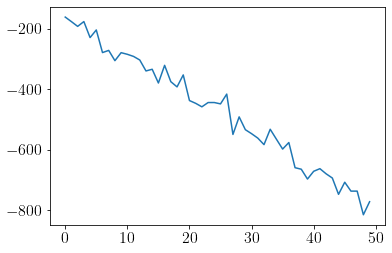

In [239]:
v = y[50:100]
plt.plot(v)

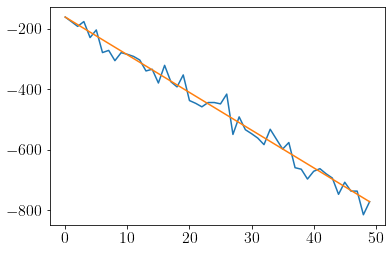

In [240]:
v0 = np.linspace(v[0], v[-1], len(v))
plt.plot(v)
plt.plot(v0)

In [243]:
np.std(v - v0)

26.222703991263014

Clearly, we have a reasonable estimate for $\sigma_y$. It took a visual inspection of the series, though. Can we estimate $\sigma_b$?

In [250]:
import pandas as pd

<AxesSubplot:>

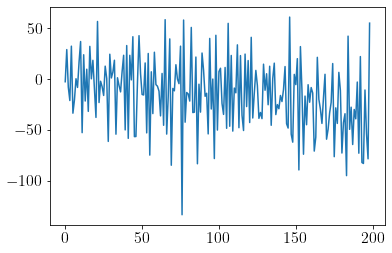

In [299]:
pd.Series(np.diff(y)).plot()

<AxesSubplot:>

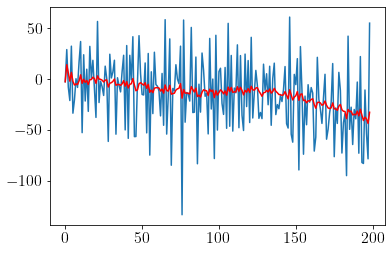

In [300]:
pd.Series(np.diff(y)).plot()
b_est = pd.Series(np.diff(y)).ewm(8).mean()
b_est.plot(color='red')

Note that true $b_t$, according to the state equations, is simple diffusion:

$$
b_t=b_{t-1}+\epsilon_t^b, \quad \epsilon_t^b\sim \mathcal{N}(0, \sigma_b)
$$

How do we estimate the diffusion coefficient?

In [272]:
# this is in fact quite a poor estimate
b_est.diff().std()

4.374319242590197

<AxesSubplot:>

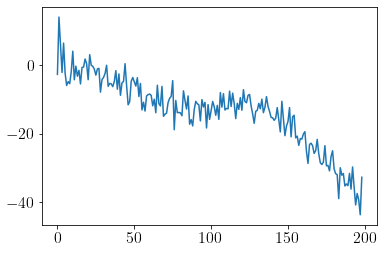

In [385]:
b_est.plot()

In [386]:
[(b_est[i+30]-b_est[i])**2 for i in [0, 30, 60, 90, 120, 150]]

[0.8212194305172539,
 23.486299233836316,
 4.517377802883887,
 6.851752126813343,
 10.679288755116874,
 192.53078019305923]

In [296]:
# we have to smoothen the fast oscillations
# this is a reasonable estimate of the rms of the single-step displacement
np.mean([(b_est[i+30]-b_est[i])**2 for i in [0, 30, 60, 90, 120, 150]])**0.5/np.sqrt(30)

1.1520192840357097

# Estimation of system and observation noise for 1D motion

Overall, its clear that this approach to estimation of the parameters is quite complicated and would be not trivial to algorithmise. Here we discuss another approach, that is to maximize the likelihood of the model wrt unknown model parameters. Dealing with LLT model will be part of your homework, we will now briefly discuss a simpler problem of 1D motion.

The state equation: $x_{t}=x_{t-1} + u_{t-1} + \epsilon_{t-1}$

The observational equation: $z_{t}=x_{t} + \eta_{t}$

Consider constant velocity $u=1$. Our task will be to estimate the std of $\epsilon$ and $\eta$.

In [387]:
z = np.load("z_1d2.npy")

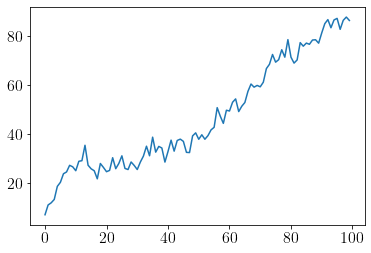

In [388]:
plt.plot(z)

Consider, for simplicity and possibility to wrfor write down explicit equation, the case of just 3 observations, to begin with.

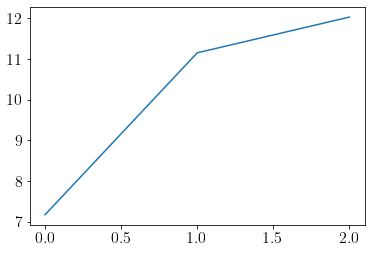

In [389]:
plt.plot(z[:3])

The log-likelihood of hidden states $x_0, x_1, x_2$ for these observations reads:

$$
\ln P(x|z,\rho,\sigma) = -\frac{3}{2} \log \left(2 \pi  \rho ^2\right)-\log \left(2 \pi  \sigma ^2\right)-\frac{\left(-x_0+x_1-1\right){}^2}{2 \sigma ^2}-\frac{\left(-x_1+x_2-1\right){}^2}{2 \sigma ^2}-\frac{\left(x_0-z_0\right){}^2}{2 \rho ^2}-\frac{\left(x_1-z_1\right){}^2}{2 \rho ^2}-\frac{\left(x_2-z_2\right){}^2}{2 \rho ^2}
$$

Whats the origin of this expression?

We dont the hidden states, so lets just integrate them out. The integral can be computed explicitely (it is a standard Gaussian integral). here we compute it analytically but in general case, jax can be used to have a quick numerical evaluation. Analytically, we find (check):

$$
P(\rho,\sigma,z)\propto \int P(x|z,\rho,\sigma) dx_0 dx_1 dx_2 = \frac{1}{2 \pi  \sqrt{\left(\rho ^2+\sigma ^2\right) \left(3 \rho ^2+\sigma ^2\right)}} e^{-\frac{1}{2}z A z^T + w z + b}
$$

$$
A = \left(
\begin{array}{ccc}
 \frac{2 \rho ^2+\sigma ^2}{3 \rho ^4+4 \rho ^2 \sigma ^2+\sigma ^4} & -\frac{1}{3 \rho ^2+\sigma ^2} & -\frac{\rho ^2}{3 \rho ^4+4 \rho ^2 \sigma ^2+\sigma ^4} \\
 -\frac{1}{3 \rho ^2+\sigma ^2} & \frac{2}{3 \rho ^2+\sigma ^2} & -\frac{1}{3 \rho ^2+\sigma ^2} \\
 -\frac{\rho ^2}{3 \rho ^4+4 \rho ^2 \sigma ^2+\sigma ^4} & -\frac{1}{3 \rho ^2+\sigma ^2} & \frac{2 \rho ^2+\sigma ^2}{3 \rho ^4+4 \rho ^2 \sigma ^2+\sigma ^4} \\
\end{array}
\right)
$$

$$
w = \left(-\frac{1}{\rho ^2+\sigma ^2},0,\frac{1}{\rho ^2+\sigma ^2}\right)
$$

$$
b = -\frac{1}{\rho ^2+\sigma ^2}
$$

This form is valid for arbitrary set of observations $z_{0}, z_{1}, z_{2}$. Now we may substitue actual observations (see the graph above) to obtain

$$
P(\rho,\sigma)\propto \frac{e^{-\frac{8.54304 \rho ^2+4.45038 \sigma ^2}{\left(\rho ^2+\sigma ^2\right) \left(3 \rho ^2+\sigma ^2\right)}}}{2 \pi  \sqrt{\left(\rho ^2+\sigma ^2\right) \left(3 \rho ^2+\sigma ^2\right)}}
$$

In [337]:
def logp(s, r):
    return -0.5*np.log((r**2+s**2)*(3*r**2+s**2)) - (8.543*r**2 + 4.450*s**2) / ((r**2+s**2)*(3*r**2+s**2))

This expression has to be maximized over $\rho$ and $\sigma$. Here a maximum can be found to lie at $\sigma=1.93$ and $\rho=0.59$.

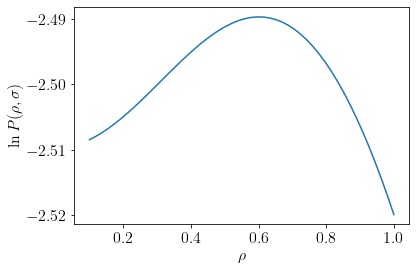

In [349]:
xs = np.linspace(0.1, 1)
plt.plot(xs, [logp(1.93, x) for x in xs])
plt.xlabel("$\\rho$")
plt.ylabel("$\\ln P(\\rho,\\sigma)$");

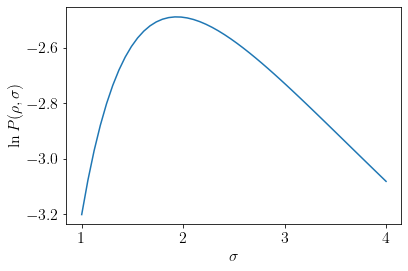

In [351]:
xs = np.linspace(1, 4)
plt.plot(xs, [logp(x, 0.59) for x in xs])
plt.xlabel("$\\sigma$")
plt.ylabel("$\\ln P(\\rho,\\sigma)$");

Thus, MLE for the parameters of the process are $\sigma=1.93$ and $\rho=0.59$ which are not too far from the correct ones, which you will have to compute in the HW.